# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Dense, Concatenate, Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,
                                     LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report

# Helper Functions

In [2]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-10 21:37:59--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-10 21:37:59 (93.8 MB/s) - ‘helper_functions.py’ saved [7752/7752]



In [3]:
from helper_functions import (make_confusion_matrix, plot_loss_curves, calculate_results, plot_class_accuracy,
                              plot_prediction_confidence_histogram, create_tensorboard_callback)

In [145]:
def plot_loss_curves(history):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['recall_1'])
    val_accuracy = np.array(history.history['val_recall_1'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_recall', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_recall', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Recall (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

# Data Downloading

In [5]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d namanj27/ner-dataset
! unzip "/content/ner-dataset.zip" -d "/content/dataset/"

100% 3.17M/3.17M [00:01<00:00, 3.62MB/s]
100% 3.17M/3.17M [00:01<00:00, 2.72MB/s]
Archive:  /content/ner-dataset.zip
  inflating: /content/dataset/ner_datasetreference.csv  


# Data Loading

In [98]:
data_path = "/content/dataset/ner_datasetreference.csv"
df = pd.read_csv(data_path, encoding='unicode_escape')
df.fillna(method='ffill', inplace=True)
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  1048575 non-null  object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [100]:
df.describe()

,Sentence #,Word,POS,Tag
count,1048575,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 22480,the,NN,O
freq,104,52573,145807,887908


In [101]:
print("Number of unique words in the dataset: {}".format(df['Word'].nunique()))
print("Number of unique tags in the dataset: {}".format(df['Tag'].nunique()))

Number of unique words in the dataset: 35178
Number of unique tags in the dataset: 17


In [102]:
df['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [103]:
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [104]:
aggregate_func = lambda s:[(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                        s['POS'].values.tolist(),
                                                        s['Tag'].values.tolist())]

In [105]:
dataset = df.groupby(['Sentence #']).apply(aggregate_func).reset_index().rename(columns={0:'Sentence_POS_Tag_Pair'})
dataset.head(5)

,Sentence #,Sentence_POS_Tag_Pair
0,Sentence: 1,"[(Thousands, NNS, O), (of, IN, O), (demonstrat..."
1,Sentence: 10,"[(Iranian, JJ, B-gpe), (officials, NNS, O), (s..."
2,Sentence: 100,"[(Helicopter, NN, O), (gunships, NNS, O), (Sat..."
3,Sentence: 1000,"[(They, PRP, O), (left, VBD, O), (after, IN, O..."
4,Sentence: 10000,"[(U.N., NNP, B-geo), (relief, NN, O), (coordin..."


In [106]:
dataset['Sentence'] = dataset['Sentence_POS_Tag_Pair'].apply(lambda sentence:" ".join([s[0] for s in sentence]))
dataset['POS'] = dataset['Sentence_POS_Tag_Pair'].apply(lambda sentence:" ".join([s[1] for s in sentence]))
dataset['Tag'] = dataset['Sentence_POS_Tag_Pair'].apply(lambda sentence:" ".join([s[2] for s in sentence]))

In [107]:
dataset['Sentences_list'] = dataset['Sentence'].apply(lambda x:x.split())
dataset['Tag_list'] = dataset['Tag'].apply(lambda x:x.split())

In [108]:
dataset['Sentence_len'] = dataset['Sentences_list'].apply(lambda x: len(x))
dataset['Tag_len'] = dataset['Tag_list'].apply(lambda x:len(x))
dataset['Equal'] = dataset.apply(lambda row: 1 if row['Sentence_len'] == row['Tag_len'] else 0, axis=1)

In [109]:
dataset.head(3)

,Sentence #,Sentence_POS_Tag_Pair,Sentence,POS,Tag,Sentences_list,Tag_list,Sentence_len,Tag_len,Equal
0,Sentence: 1,"[(Thousands, NNS, O), (of, IN, O), (demonstrat...",Thousands of demonstrators have marched throug...,NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP C...,O O O O O O B-geo O O O O O B-geo O O O O O B-...,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...",24,24,1
1,Sentence: 10,"[(Iranian, JJ, B-gpe), (officials, NNS, O), (s...",Iranian officials say they expect to get acces...,JJ NNS VBP PRP VBP TO VB NN TO JJ JJ NNS IN DT...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...",25,25,1
2,Sentence: 100,"[(Helicopter, NN, O), (gunships, NNS, O), (Sat...",Helicopter gunships Saturday pounded militant ...,"NN NNS NNP VBD JJ NNS IN DT NNP JJ NN , WRB JJ...",O O B-tim O O O O O B-geo O O O O O B-org O O ...,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...",32,32,1


In [110]:
dataset['Equal'].value_counts()

1    47955
0        4
Name: Equal, dtype: int64

In [111]:
dataset = dataset[dataset['Equal'] != 0]

In [112]:
dataset.shape

(47955, 10)

In [113]:
sentences_list = dataset['Sentence'].tolist()
tags_list = dataset['Tag_list'].tolist()

In [114]:
print("Total number of sentences in dataset:", len(sentences_list))
print("Total number of tags in dataset:", len(tags_list))

Total number of sentences in dataset: 47955
Total number of tags in dataset: 47955


## Sentence with respect to their tag

In [115]:
print("Sentence: ", sentences_list[0])
print("NER Tags:", tags_list[0])

Sentence:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
NER Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


# Word Length

In [116]:
sentences_length = [len(sentence.split()) for sentence in sentences_list]
avg_sentence_length = np.mean(sentences_length)
print(avg_sentence_length)

21.862683766030653


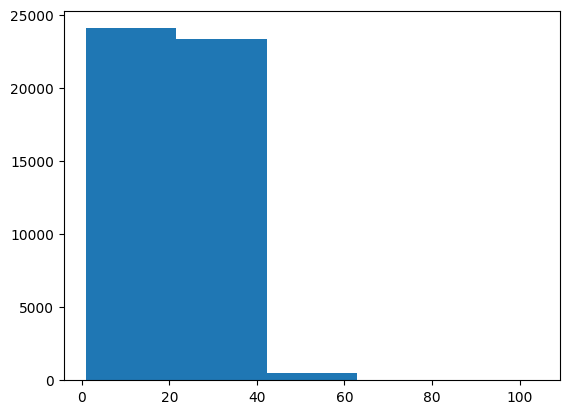

In [117]:
plt.hist(sentences_length, bins=5);

In [118]:
output_sequence_length = int(np.percentile(sentences_length, 100))
print(output_sequence_length)

104


In [119]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(sentences_list)

In [120]:
print("Vocab size of tokenizer ", len(tokenizer.index_word) + 1) ## adding one since 0 is reserved for padding

Vocab size of tokenizer  35170


In [121]:
tokenizer.index_word[100]

'out'

In [122]:
encoded_sentence = tokenizer.texts_to_sequences(sentences_list)

print("First Original Sentence: \n", sentences_list[0])
print("First Encoded Sentence:\n", encoded_sentence[0])
print("Is Length of Original Sentence Same as Encoded Sentence:",len(sentences_list[0].split())==len(encoded_sentence[0]))
print("Length of First Sentence: ", len(encoded_sentence[0]))

First Original Sentence: 
 Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
First Encoded Sentence:
 [1114, 4, 1161, 16, 1852, 230, 478, 6, 533, 1, 155, 5, 58, 8, 582, 1, 843, 4, 179, 87, 21, 15, 52, 2]
Is Length of Original Sentence Same as Encoded Sentence: True
Length of First Sentence:  24


In [123]:
tags = list(set(df['Tag'].values))
num_tags = len(tags)
print("Tags:", tags)
print("Total count of tags:",num_tags)

Tags: ['I-geo', 'B-org', 'I-eve', 'B-eve', 'I-tim', 'I-gpe', 'I-nat', 'B-per', 'O', 'I-per', 'B-nat', 'B-art', 'I-org', 'B-geo', 'I-art', 'B-tim', 'B-gpe']
Total count of tags: 17


In [124]:
tags_map = {tag:i for i, tag in enumerate(tags)}
reverse_tag_map={v: k for k, v in tags_map.items()}
print("Tags Mapping",tags_map)
print("Reverse Tags Mapping", reverse_tag_map)

Tags Mapping {'I-geo': 0, 'B-org': 1, 'I-eve': 2, 'B-eve': 3, 'I-tim': 4, 'I-gpe': 5, 'I-nat': 6, 'B-per': 7, 'O': 8, 'I-per': 9, 'B-nat': 10, 'B-art': 11, 'I-org': 12, 'B-geo': 13, 'I-art': 14, 'B-tim': 15, 'B-gpe': 16}
Reverse Tags Mapping {0: 'I-geo', 1: 'B-org', 2: 'I-eve', 3: 'B-eve', 4: 'I-tim', 5: 'I-gpe', 6: 'I-nat', 7: 'B-per', 8: 'O', 9: 'I-per', 10: 'B-nat', 11: 'B-art', 12: 'I-org', 13: 'B-geo', 14: 'I-art', 15: 'B-tim', 16: 'B-gpe'}


In [125]:
encoded_tags=[[tags_map[w] for w in tag] for tag in tags_list]
print("First Sentence:\n",sentences_list[0])
print('First Sentence Original Tags:\n',tags_list[0])
print("First Sentence Encoded Tags:\n ",encoded_tags[0])
print("Is length of Original Tags and Encoded Tags same: ",len(tags_list[0])==len(encoded_tags[0]))
print("Length of Tags for First Sentence: ",len(encoded_tags[0]))

First Sentence:
 Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
First Sentence Original Tags:
 ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
First Sentence Encoded Tags:
  [8, 8, 8, 8, 8, 8, 13, 8, 8, 8, 8, 8, 13, 8, 8, 8, 8, 8, 16, 8, 8, 8, 8, 8]
Is length of Original Tags and Encoded Tags same:  True
Length of Tags for First Sentence:  24


In [126]:
max_len = 104
pad_encoded_sentences = pad_sequences(maxlen = max_len, sequences=encoded_sentence, padding='post', value=0)
pad_encoded_tags = pad_sequences(maxlen = max_len, sequences=encoded_tags, padding='post', value=tags_map['O'])

In [127]:
print("Shape of Encoded Sentence: ", pad_encoded_sentences.shape)
print("Shape of Encoded Labels: ", pad_encoded_tags.shape)

Shape of Encoded Sentence:  (47955, 104)
Shape of Encoded Labels:  (47955, 104)


In [128]:
print("First Encoded Sentence Without Padding:\n", encoded_sentence[0])
print("First Encoded Sentence with padding:\n", pad_encoded_sentences[0])
print("First Sentence Encoded Label without Padding:\n", encoded_tags[0])
print("First Sentence Encoded Label with Padding:\n", pad_encoded_tags[0])

First Encoded Sentence Without Padding:
 [1114, 4, 1161, 16, 1852, 230, 478, 6, 533, 1, 155, 5, 58, 8, 582, 1, 843, 4, 179, 87, 21, 15, 52, 2]
First Encoded Sentence with padding:
 [1114    4 1161   16 1852  230  478    6  533    1  155    5   58    8
  582    1  843    4  179   87   21   15   52    2    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
First Sentence Encoded Label without Padding:
 [8, 8, 8, 8, 8, 8, 13, 8, 8, 8, 8, 8, 13, 8, 8, 8, 8, 8, 16, 8, 8, 8, 8, 8]
First Sentence Encoded Label with Padding:
 [ 8  8  8  8  8  8 13  8  8  8  8  8 13  8  8  8  8  8 16  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  

In [129]:
target= [to_categorical(i, num_classes = num_tags) for i in  pad_encoded_tags]
print("Shape of Labels  after converting to Categorical for first sentence: ",target[0].shape)

Shape of Labels  after converting to Categorical for first sentence:  (104, 17)


In [130]:
X_train, X_test, y_train, y_test = train_test_split(pad_encoded_sentences, target, test_size=0.20)

print("Train input data shape:", X_train.shape)
print("Train label data shape:", len(y_train))
print("Test input data shape:", X_test.shape)
print("Test label data shape:", len(y_test))

Train input data shape: (38364, 104)
Train label data shape: 38364
Test input data shape: (9591, 104)
Test label data shape: 9591


In [131]:
y_train[0].shape

(104, 17)

In [132]:
print("First Sentence in Training Data: ", X_train[0])
print("First sentence Label: ", y_train[0])
print("Shape of First Sentence Train: ", X_train[0].shape)
print("Shape of First Sentence Label Train: ", y_train[0].shape)

First Sentence in Training Data:  [ 333 1937   13 1078    6  893  553   68 1019    5  108    6 4470 1743
  229  387 1086   22    1 9819  711   23    1  267    4  190  717 1152
    2    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
First sentence Label:  [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape of First Sentence Train:  (104,)
Shape of First Sentence Label Train:  (104, 17)


In [133]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [134]:
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [135]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 104), dtype=tf.int32, name=None), TensorSpec(shape=(None, 104, 17), dtype=tf.float32, name=None))>

# Model

In [136]:
EMBEDDING_DIM = 128
VOCAB_SIZE = len(tokenizer.word_index) + 1
LSTM_UNITS = 128
MAX_LEN = 104

input_layer = Input(shape=(MAX_LEN,), name='input_layer')
x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN)(input_layer)
x = Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = TimeDistributed(Dense(MAX_LEN, activation='relu'))(x)
x = Dropout(0.5)(x)
x = TimeDistributed(Dense(MAX_LEN, activation='relu'))(x)
x = Dropout(0.5)(x)
x = TimeDistributed(Dense(MAX_LEN, activation='relu'))(x)
output_layer = TimeDistributed(Dense(num_tags, activation='softmax'))(x)

model = Model(inputs=input_layer,
              outputs=output_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 104)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 104, 128)          4501760   
                                                                 
 bidirectional_2 (Bidirecti  (None, 104, 256)          263168    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 104, 256)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 104, 256)          394240    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 104, 256)          0   

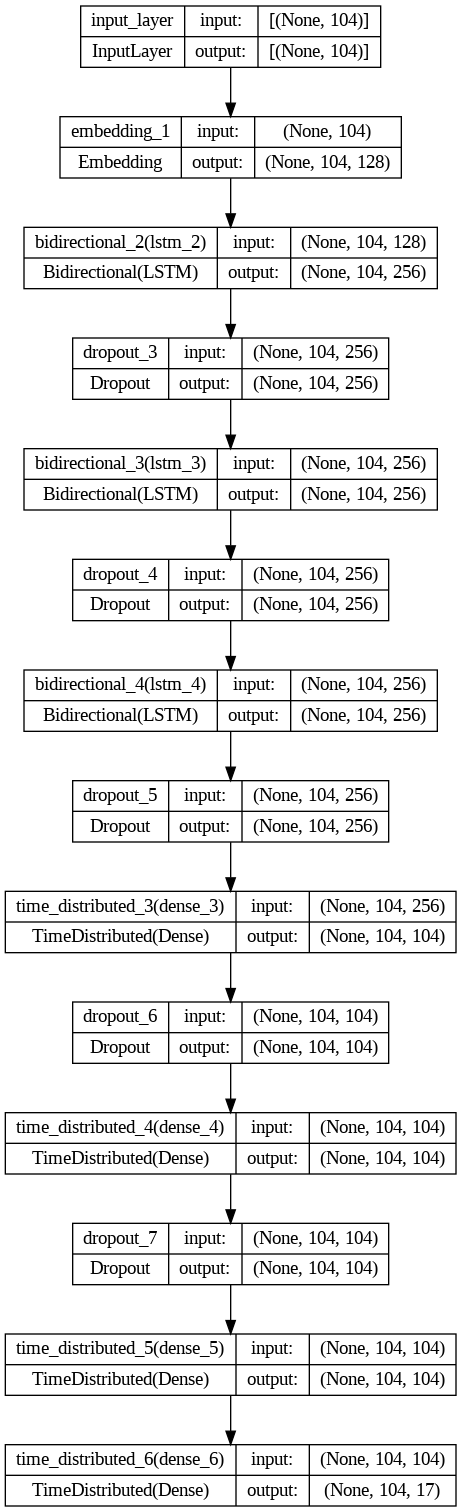

In [137]:
plot_model(model, show_shapes=True)

In [138]:
from keras import metrics

In [139]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=[metrics.Recall()])

In [140]:
history = model.fit(train_dataset,
                    validation_data = test_dataset,
                    epochs=10)

Epoch 1/10
1199/1199 [==============================] - 83s 59ms/step - loss: 0.1146 - recall_1: 0.9607 - val_loss: 0.0514 - val_recall_1: 0.9749
Epoch 2/10
1199/1199 [==============================] - 40s 34ms/step - loss: 0.0446 - recall_1: 0.9817 - val_loss: 0.0315 - val_recall_1: 0.9895
Epoch 3/10
1199/1199 [==============================] - 41s 34ms/step - loss: 0.0295 - recall_1: 0.9897 - val_loss: 0.0277 - val_recall_1: 0.9912
Epoch 4/10
1199/1199 [==============================] - 42s 35ms/step - loss: 0.0237 - recall_1: 0.9921 - val_loss: 0.0267 - val_recall_1: 0.9912
Epoch 5/10
1199/1199 [==============================] - 42s 35ms/step - loss: 0.0205 - recall_1: 0.9932 - val_loss: 0.0270 - val_recall_1: 0.9920
Epoch 6/10
1199/1199 [==============================] - 43s 36ms/step - loss: 0.0183 - recall_1: 0.9940 - val_loss: 0.0279 - val_recall_1: 0.9918
Epoch 7/10
1199/1199 [==============================] - 40s 34ms/step - loss: 0.0165 - recall_1: 0.9946 - val_loss: 0.0277 -

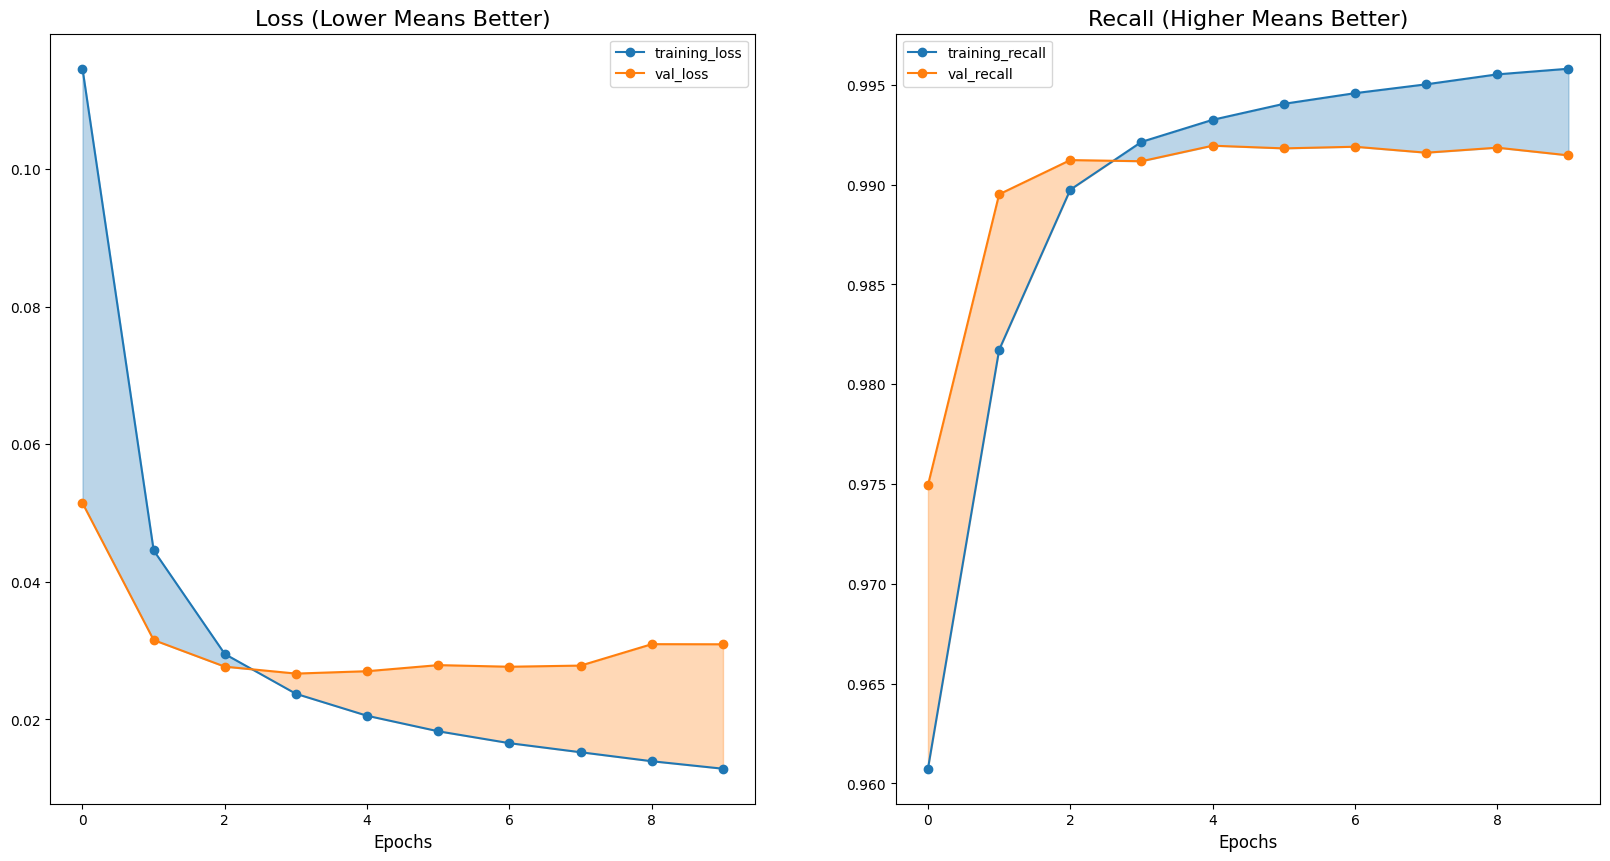

In [146]:
plot_loss_curves(history)

# Model Evaluation

In [147]:
model_pred_probs = model.predict(test_dataset, verbose=1)

300/300 [==============================] - 5s 12ms/step


In [148]:
model_preds = tf.argmax(model_pred_probs, axis=2)
model_preds[:1]

<tf.Tensor: shape=(1, 104), dtype=int64, numpy=
array([[ 8,  1, 16,  8,  8,  8,  8,  1,  8,  8,  8,  8,  8,  8,  8, 15,
         8, 16,  8,  8,  8,  8,  8, 13,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8]])>

In [149]:
true_value = np.array(tf.argmax(y_test, axis=2))
predicted_value = np.array(model_preds)

In [150]:
actual_word_label = []
predicted_word_label = []
for i in range(len(true_value)):
   actual_word_label.append(list(true_value[i]))
   predicted_word_label.append(list(predicted_value[i]))

actual_label = []
predicted_label = []
for i in range(len(actual_word_label)):
  for actual, predicted in zip(actual_word_label[i], predicted_word_label[i]):
    actual_label.append(actual)
    predicted_label.append(predicted)

In [151]:
model_1_results = calculate_results(y_true = actual_label,
                                    y_pred = predicted_label)
model_1_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 99.26754248774893,
 'precision': 0.9923939554970231,
 'recall': 0.9926754248774893,
 'f1': 0.992511165105036}

Confusion Matrix


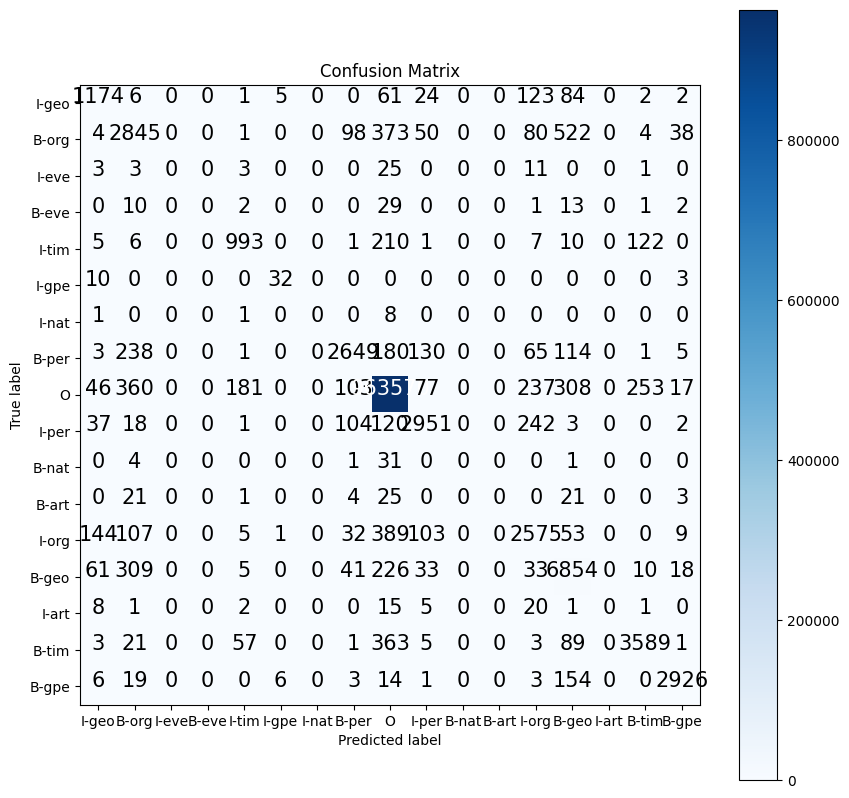

In [152]:
print("Confusion Matrix")
make_confusion_matrix(y_true = actual_label,
                      y_pred = predicted_label,
                      classes = tags,
                      figsize = (10, 10))

In [153]:
print("Classification Report")
print(classification_report(actual_label, predicted_label))

Classification Report


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1482
           1       0.72      0.71      0.71      4015
           2       0.00      0.00      0.00        46
           3       0.00      0.00      0.00        58
           4       0.79      0.73      0.76      1355
           5       0.73      0.71      0.72        45
           6       0.00      0.00      0.00        10
           7       0.87      0.78      0.82      3386
           8       1.00      1.00      1.00    965152
           9       0.87      0.85      0.86      3478
          10       0.00      0.00      0.00        37
          11       0.00      0.00      0.00        75
          12       0.76      0.75      0.76      3418
          13       0.83      0.90      0.87      7590
          14       0.00      0.00      0.00        53
          15       0.90      0.87      0.88      4132
          16       0.97      0.93      0.95      3132

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model at inference

In [154]:
sentence = "Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country."
encoded_sentence = tokenizer.texts_to_sequences([sentence])
pad_sentence = pad_sequences(maxlen=max_len, sequences=encoded_sentence, padding='post', value=0)
prediction = model.predict(pad_sentence)
prediction = np.argmax(prediction, axis=2)[0]
final_pred = [reverse_tag_map[tag] for tag in prediction]
print("sentence: ", sentence)
length_of_sentence = len(sentence.split(' '))
print("Tags: ", final_pred[:length_of_sentence])

1/1 [==============================] - 2s 2s/step
sentence:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country.
Tags:  ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O']


# Saving Model

In [155]:
model.save("Named_Entity_Recognition_Model")

In [ ]:
import pickle

with open('tokenizer.pkl', 'wb') as token_file:
    pickle.dump(tokenizer, token_file)

with open('padded_sequences.pkl', 'wb') as sequences_file:
    pickle.dump(pad_sequences, sequences_file)

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [157]:
%cp -av /content/Named_Entity_Recognition_Model /content/drive/MyDrive/Named_Entity_Recognition_Model/

'/content/Named_Entity_Recognition_Model' -> '/content/drive/MyDrive/Named_Entity_Recognition_Model/'
'/content/Named_Entity_Recognition_Model/variables' -> '/content/drive/MyDrive/Named_Entity_Recognition_Model/variables'
'/content/Named_Entity_Recognition_Model/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/Named_Entity_Recognition_Model/variables/variables.data-00000-of-00001'
'/content/Named_Entity_Recognition_Model/variables/variables.index' -> '/content/drive/MyDrive/Named_Entity_Recognition_Model/variables/variables.index'
'/content/Named_Entity_Recognition_Model/assets' -> '/content/drive/MyDrive/Named_Entity_Recognition_Model/assets'
'/content/Named_Entity_Recognition_Model/fingerprint.pb' -> '/content/drive/MyDrive/Named_Entity_Recognition_Model/fingerprint.pb'
'/content/Named_Entity_Recognition_Model/saved_model.pb' -> '/content/drive/MyDrive/Named_Entity_Recognition_Model/saved_model.pb'
'/content/Named_Entity_Recognition_Model/keras_metadata.pb' -> '/c

# Hugging Face Model

In [158]:
! pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.6 MB/s eta 0:00:00


In [159]:
from huggingface_hub import notebook_login
notebook_login()

In [160]:
path = "/content/drive/MyDrive/Named_Entity_Recognition_Model"
model = tf.keras.models.load_model(path)

In [161]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = model, repo_id = "DriveMyScream/Named_Entity_Recognition")

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/6.11M [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

'https://huggingface.co/DriveMyScream/Named_Entity_Recognition/tree/main/'

In [162]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/Named_Entity_Recognition")

config.json not found in HuggingFace Hub.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [167]:
import pickle

with open('/content/drive/MyDrive/Named_Entity_Recognition_model/vectorize_layers/tokenizer.pkl', 'rb') as token_file:
    loaded_tokenizer = pickle.load(token_file)

with open('/content/drive/MyDrive/Named_Entity_Recognition_model/vectorize_layers/padded_sequences.pkl', 'rb') as sequences_file:
    loaded_padded_sequences = pickle.load(sequences_file)

In [168]:
sentence = "Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country."
reverse_tag_map = {0: 'I-geo', 1: 'B-org', 2: 'I-eve', 3: 'B-eve', 4: 'I-tim', 5: 'I-gpe', 6: 'I-nat', 7: 'B-per', 8: 'O', 9: 'I-per', 10: 'B-nat', 11: 'B-art', 12: 'I-org', 13: 'B-geo', 14: 'I-art', 15: 'B-tim', 16: 'B-gpe'}
encoded_sentence = loaded_tokenizer.texts_to_sequences([sentence])
pad_sentence = loaded_padded_sequences(maxlen=max_len, sequences=encoded_sentence, padding='post', value=0)
prediction = loaded_model.predict(pad_sentence)
prediction = np.argmax(prediction, axis=2)[0]
final_pred = [reverse_tag_map[tag] for tag in prediction]
print("sentence: ", sentence)
length_of_sentence = len(sentence.split(' '))
print("Tags: ", final_pred[:length_of_sentence])

1/1 [==============================] - 0s 37ms/step
sentence:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country.
Tags:  ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O']


# Tensorflow Lite model

In [164]:
import tensorflow as tf

path = "/content/drive/MyDrive/Named_Entity_Recognition_Model"
model = tf.keras.models.load_model(path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Named_Entity_Recognition_Model.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
import pickle

with open('/content/drive/MyDrive/Named_Entity_Recognition_model/vectorize_layers/tokenizer.pkl', 'rb') as token_file:
    loaded_tokenizer = pickle.load(token_file)

with open('/content/drive/MyDrive/Named_Entity_Recognition_model/vectorize_layers/padded_sequences.pkl', 'rb') as sequences_file:
    loaded_padded_sequences = pickle.load(sequences_file)

In [178]:
model_path = "/content/Named_Entity_Recognition_Model.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

sentence = "Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country."
reverse_tag_map = {0: 'I-geo', 1: 'B-org', 2: 'I-eve', 3: 'B-eve', 4: 'I-tim', 5: 'I-gpe', 6: 'I-nat', 7: 'B-per', 8: 'O', 9: 'I-per', 10: 'B-nat', 11: 'B-art', 12: 'I-org', 13: 'B-geo', 14: 'I-art', 15: 'B-tim', 16: 'B-gpe'}
encoded_sentence = loaded_tokenizer.texts_to_sequences([sentence])
pad_sentence = loaded_padded_sequences(maxlen=input_details[0]['shape'][1], sequences=encoded_sentence, padding='post', value=tags_map['O'])
pad_sentence = pad_sentence.astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], pad_sentence)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
prediction = np.argmax(output_data, axis=2)[0]
final_pred = [reverse_tag_map[tag] for tag in prediction]
print("sentence: ", sentence)
length_of_sentence = len(sentence.split(' '))
print("Tags: ", final_pred[:length_of_sentence])

sentence:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country.
Tags:  ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O']
